# IRON KAGGLE

- **shop_ID**: Unique identifier for each shop.
- **day_of_the_week**: Encoded from 1 to 7, representing the day of the week.
- **date**: Day, month, and year of the data point.
- **number_of_customers**: Quantity of customers that visited the shop on that day.
- **open**: Binary variable; 0 means the shop was closed, while 1 means it was open.
- **promotion**: Binary variable; 0 means no promotions, 1 means there were promotions.
- **state_holiday**: Encoded as 0, 'a', 'b', 'c', indicating the presence of a state holiday (0 if none). 'a', 'b', 'c' represent different state holidays.
- **school_holiday**: Binary variable; 0 means no school holiday, 1 means there was a school holiday.

## Lib Loading

In [1]:
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


## Data Loading

In [2]:
data = pd.read_csv('data/sales.csv')
sales_df = data.copy()

## Data Exploration

In [3]:
display(sales_df.shape)
display(sales_df.head())
display(sales_df.info())
display(sales_df.isna().sum())
display(sales_df.duplicated().sum())

(640840, 10)

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales
0,0,625,3,2013-11-06,641,1,1,0,0,7293
1,1,293,2,2013-07-16,877,1,1,0,1,7060
2,2,39,4,2014-01-23,561,1,1,0,0,4565
3,3,676,4,2013-09-26,1584,1,1,0,0,6380
4,4,709,3,2014-01-22,1477,1,1,0,0,11647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   True_index           640840 non-null  int64 
 1   Store_ID             640840 non-null  int64 
 2   Day_of_week          640840 non-null  int64 
 3   Date                 640840 non-null  object
 4   Nb_customers_on_day  640840 non-null  int64 
 5   Open                 640840 non-null  int64 
 6   Promotion            640840 non-null  int64 
 7   State_holiday        640840 non-null  object
 8   School_holiday       640840 non-null  int64 
 9   Sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


None

True_index             0
Store_ID               0
Day_of_week            0
Date                   0
Nb_customers_on_day    0
Open                   0
Promotion              0
State_holiday          0
School_holiday         0
Sales                  0
dtype: int64

0

## Data Cleaning

In [4]:
#Remove open 0 
sales_df = sales_df[sales_df['Open'] != 0]

## Feature Engineering

### Dates

In [5]:
sales_df['Date'] = pd.to_datetime(data['Date'])

# Split the dates
sales_df['Year'] = sales_df['Date'].dt.year
sales_df['Month'] = sales_df['Date'].dt.month
sales_df['Day'] = sales_df['Date'].dt.day

### Categories

In [6]:
# Display the updated dataframe
display(sales_df.head())

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales,Year,Month,Day
0,0,625,3,2013-11-06,641,1,1,0,0,7293,2013,11,6
1,1,293,2,2013-07-16,877,1,1,0,1,7060,2013,7,16
2,2,39,4,2014-01-23,561,1,1,0,0,4565,2014,1,23
3,3,676,4,2013-09-26,1584,1,1,0,0,6380,2013,9,26
4,4,709,3,2014-01-22,1477,1,1,0,0,11647,2014,1,22


### Additional Features

In [7]:
# Is the day a weekend?
sales_df['Is_weekend'] = sales_df['Day_of_week'].apply(lambda x: 1 if x >= 6 else 0)


# Add a column to indicate if promotions and holidays are concurrent
# Calculate sales per customer
sales_df['Sales_per_customer'] = sales_df['Sales'] / sales_df['Nb_customers_on_day']

# Create interaction features
#sales_df['Promo_Holiday'] = sales_df['Promotion'] * sales_df['State_holiday']
sales_df['Promo_School_Holiday'] = sales_df['Promotion'] * sales_df['School_holiday']

In [8]:
store_stats = sales_df.groupby('Store_ID').agg({
    'Sales': ['mean', 'std', 'median'],
    'Nb_customers_on_day': ['mean', 'std', 'median'],
    'Promotion': 'mean',  # Promotion frequency
    'School_holiday': 'mean',  # School holiday frequency
}).reset_index()

# Flatten column names
store_stats.columns = ['Store_ID'] + [
    f'Store_{x[0]}_{x[1]}' for x in store_stats.columns[1:]
]

# Calculate store performance quartiles
store_stats['Store_sales_quartile'] = pd.qcut(
    store_stats['Store_Sales_mean'], 
    q=4, 
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)

sales_df = sales_df.merge(store_stats, on='Store_ID')

In [9]:
# converts the state holiday column to multiple binary columns
sales_df = pd.get_dummies(sales_df, columns=['State_holiday','Store_sales_quartile'], drop_first=True)

### DF Check

In [10]:
display(sales_df.head())

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,School_holiday,Sales,Year,...,Store_Nb_customers_on_day_std,Store_Nb_customers_on_day_median,Store_Promotion_mean,Store_School_holiday_mean,State_holiday_a,State_holiday_b,State_holiday_c,Store_sales_quartile_Q2,Store_sales_quartile_Q3,Store_sales_quartile_Q4
0,0,625,3,2013-11-06,641,1,1,0,7293,2013,...,126.897154,604.0,0.425620,0.196281,False,False,False,True,False,False
1,1,293,2,2013-07-16,877,1,1,1,7060,2013,...,149.273920,793.0,0.445344,0.204453,False,False,False,True,False,False
2,2,39,4,2014-01-23,561,1,1,0,4565,2014,...,175.997236,589.0,0.419028,0.214575,False,False,False,False,False,False
3,3,676,4,2013-09-26,1584,1,1,0,6380,2013,...,339.529406,1728.0,0.390244,0.193380,False,False,False,False,True,False
4,4,709,3,2014-01-22,1477,1,1,0,11647,2014,...,392.191173,1413.0,0.460765,0.215292,False,False,False,False,False,True


## Correlation Matrix

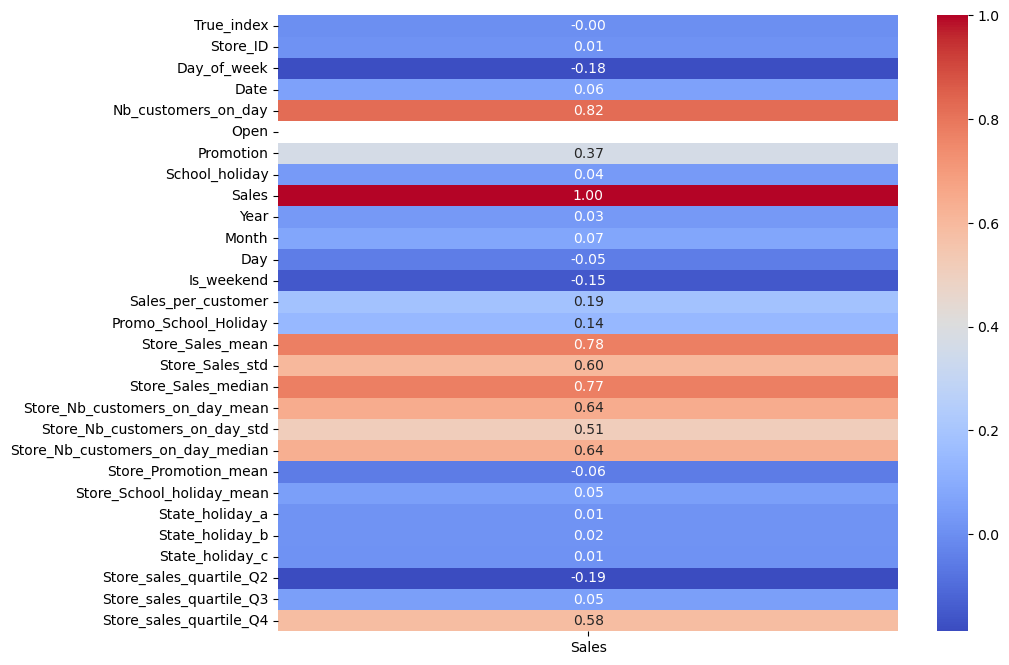

In [11]:
corr_matrix = sales_df.corr()

# just for the target column
corr_matrix_target = corr_matrix[['Sales']]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_target, annot=True, cmap='coolwarm', fmt='.2f')
plt.show() 

## Data Split

### Define feature & target

In [12]:
#TODO Drop open 0?
features = sales_df.drop(columns=['Sales','Date', 'True_index','Store_ID','Open'])
target = sales_df['Sales']

### Split the training and test

In [13]:
#TODO Try different sample sizes
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

## Scaling

In [14]:
#TODO Try different scalers

normalizer = MinMaxScaler()

normalizer.fit(X_train)

X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [15]:
display(pd.DataFrame(X_train_norm))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.333333,0.065225,0.0,0.0,0.5,0.181818,0.366667,0.0,0.184341,0.0,...,0.162653,0.065594,0.733350,0.531433,0.0,0.0,0.0,0.0,1.0,0.0
1,0.666667,0.087395,0.0,0.0,0.0,1.000000,0.400000,0.0,0.130447,0.0,...,0.038141,0.094607,0.496789,0.279583,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,0.136863,0.0,0.0,0.0,0.909091,0.933333,0.0,0.170243,0.0,...,0.183323,0.147903,0.641766,0.585039,0.0,0.0,0.0,0.0,1.0,0.0
3,0.666667,0.153903,0.0,1.0,0.5,0.363636,0.966667,0.0,0.165198,0.0,...,0.094342,0.155787,0.650907,0.338373,0.0,0.0,0.0,1.0,0.0,0.0
4,0.333333,0.080616,0.0,0.0,1.0,0.090909,0.800000,0.0,0.125638,0.0,...,0.128929,0.132450,0.586897,0.312237,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425607,0.666667,0.117259,1.0,0.0,0.0,0.727273,0.866667,0.0,0.183329,0.0,...,0.140110,0.125197,0.787425,0.630073,0.0,0.0,0.0,0.0,1.0,0.0
425608,0.500000,0.124771,0.0,1.0,1.0,0.545455,0.733333,0.0,0.128199,0.0,...,0.159370,0.176600,0.674532,0.577660,0.0,0.0,0.0,1.0,0.0,0.0
425609,0.000000,0.188897,1.0,0.0,1.0,0.363636,0.100000,0.0,0.222269,0.0,...,0.203000,0.181646,0.657394,0.577237,0.0,0.0,0.0,0.0,0.0,1.0
425610,0.500000,0.160682,0.0,0.0,0.5,0.090909,0.866667,0.0,0.100221,0.0,...,0.205749,0.192368,0.788536,0.386169,0.0,0.0,0.0,1.0,0.0,0.0


## Training

### Simple models

In [16]:
n_neighbors = 3
max_depth = None
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)

In [17]:
n_neighbors = 10
max_depth = None
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)

In [18]:
n_neighbors = None
max_depth = None
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = LinearRegression()

In [19]:
n_neighbors = None
max_depth = 10
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = DecisionTreeRegressor(max_depth=max_depth)

In [20]:
n_neighbors = None
max_depth = 1000
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = DecisionTreeRegressor(max_depth=max_depth)

In [21]:
n_neighbors = None
max_depth = 1000
n_estimators = None
max_samples = None
max_leafs_nodes = None
max_features = None

model = DecisionTreeRegressor(max_depth=max_depth)

### Ensemble

In [22]:
n_neighbors = None
max_depth = None
n_estimators = 100
max_samples = 1000
max_leafs_nodes = None
max_features = None
estimator = LinearRegression()

model = BaggingRegressor(estimator, n_estimators=n_estimators, max_samples=max_samples)

In [23]:
n_neighbors = 10
max_depth = None
n_estimators = 100
max_samples = 1000
max_leafs_nodes = None
max_features = None
estimator = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)

model = BaggingRegressor(estimator, n_estimators=n_estimators, max_samples=max_samples)

In [24]:
n_neighbors = None
max_depth = 1000
n_estimators = 100
max_samples = 1000
max_leafs_nodes = None
max_features = None
estimator = DecisionTreeRegressor(max_depth=max_depth)

model = BaggingRegressor(estimator, n_estimators=n_estimators, max_samples=max_samples)

In [25]:
n_neighbors = None
max_depth = 1000
n_estimators = 100
max_samples = 1000
max_leafs_nodes = None
max_features = None
estimator = DecisionTreeRegressor(max_depth=max_depth)

model = BaggingRegressor(estimator, n_estimators=n_estimators, max_samples=max_samples, bootstrap=False)

In [26]:
n_neighbors = None
max_depth = 1000
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = None

model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)

In [27]:
n_neighbors = None
max_depth = 100
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = DecisionTreeRegressor(max_depth=max_depth)

model = AdaBoostRegressor(n_estimators=n_estimators)

In [28]:
n_neighbors = 10
max_depth = None
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)

model = AdaBoostRegressor(n_estimators=n_estimators)

In [29]:
n_neighbors = None
max_depth = None
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = LinearRegression()

model = AdaBoostRegressor(n_estimators=n_estimators)

In [30]:
n_neighbors = None
max_depth = 100
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = None

model = GradientBoostingRegressor(max_depth=max_depth,  n_estimators=n_estimators, verbose=1)

In [31]:
n_neighbors = None
max_depth = 20
n_estimators = 100
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = None

model = GradientBoostingRegressor(max_depth=max_depth,  n_estimators=n_estimators, verbose=1)

### Active

In [32]:
n_neighbors = None
max_depth = 400
n_estimators = 50
max_samples = None
max_leafs_nodes = None
max_features = None
estimator = None

model = RandomForestRegressor(
    n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)

### Fine Tuning

In [33]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [10, 400],
}

In [34]:
#model = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, n_jobs=-1, verbose=4) 


## Evaluation

In [35]:
model.fit(X_train_norm, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END .....max_depth=10, n_estimators=50;, score=0.999 total time= 1.6min
[CV 4/5] END .....max_depth=10, n_estimators=50;, score=0.998 total time= 1.6min
[CV 1/5] END .....max_depth=10, n_estimators=50;, score=0.999 total time= 1.6min
[CV 3/5] END .....max_depth=10, n_estimators=50;, score=0.998 total time= 1.6min
[CV 5/5] END .....max_depth=10, n_estimators=50;, score=0.998 total time= 1.6min
[CV 3/5] END ....max_depth=400, n_estimators=50;, score=0.999 total time= 2.9min
[CV 2/5] END ....max_depth=400, n_estimators=50;, score=1.000 total time= 3.0min
[CV 4/5] END ....max_depth=400, n_estimators=50;, score=0.999 total time= 3.0min


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 5/5] END ....max_depth=400, n_estimators=50;, score=1.000 total time= 3.0min
[CV 1/5] END ....max_depth=400, n_estimators=50;, score=1.000 total time= 3.0min
[CV 5/5] END ....max_depth=10, n_estimators=200;, score=0.999 total time= 6.0min
[CV 3/5] END ....max_depth=10, n_estimators=200;, score=0.998 total time= 6.0min
[CV 4/5] END ....max_depth=10, n_estimators=200;, score=0.998 total time= 6.0min
[CV 2/5] END ....max_depth=10, n_estimators=200;, score=0.999 total time= 6.0min
[CV 1/5] END ....max_depth=10, n_estimators=200;, score=0.999 total time= 6.0min
[CV 1/5] END ...max_depth=400, n_estimators=200;, score=1.000 total time= 9.3min
[CV 4/5] END ...max_depth=400, n_estimators=200;, score=0.999 total time= 9.4min
[CV 2/5] END ...max_depth=400, n_estimators=200;, score=1.000 total time= 9.4min
[CV 5/5] END ...max_depth=400, n_estimators=200;, score=1.000 total time= 9.3min
[CV 3/5] END ...max_depth=400, n_estimators=200;, score=0.999 total time= 9.4min


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 400], 'n_estimators': [50, 200]},
             verbose=4)

In [39]:
best_model = model.best_estimator_
best_model

RandomForestRegressor(max_depth=400, n_estimators=200)

In [37]:
# Convert the cv_results_ to a DataFrame
results_df = pd.DataFrame(model.cv_results_)

# Define the file name
file_name = 'grid_search_results.csv'

# Check if the file already exists
if os.path.isfile(file_name):
    # If the file exists, append the new results without writing the header
    results_df.to_csv(file_name, mode='a', header=False, index=False)
else:
    # If the file does not exist, create it and write the header
    results_df.to_csv(file_name, mode='w', header=True, index=False)

In [38]:
# Get the regressor name and the estimator name programmatically
regressor_name = type(model).__name__
estimator_name = type(estimator).__name__

print(f"Regressor: {regressor_name}, Estimator: {estimator_name}")

model_name = type(model).__name__

pred = model.predict(X_test_norm)

mae = mean_absolute_error(pred, y_test)
rmse = root_mean_squared_error(pred, y_test)
r2 = model.score(X_test_norm, y_test)


# Create a DataFrame with the current model results
current_results = pd.DataFrame([{
    'Model': f'{model_name} > {estimator_name}' if 'estimator_name' in locals() else model_name,
    'n_neighbors': n_neighbors,
    'max_depth': max_depth,
    'n_estimators': n_estimators,
    'max_samples': max_samples,
    'max_leafs_nodes': max_leafs_nodes,
    'max_features' : max_features,
    'MAE': mae,
    'RMSE': rmse,
    'R2_score': r2,
}])

display(current_results)

file_name = 'results.csv'
# Check if the file already exists
if os.path.isfile(file_name):
    # If the file exists, append the new results without writing the header
    current_results.to_csv(file_name, mode='a', header=False, index=False)
else:
    # If the file does not exist, create it and write the header
    current_results.to_csv(file_name, mode='w', header=True, index=False)

Regressor: GridSearchCV, Estimator: NoneType


,Model,n_neighbors,max_depth,n_estimators,max_samples,max_leafs_nodes,max_features,MAE,RMSE,R2_score
0,GridSearchCV > NoneType,None,100,100,None,None,None,7.405009,53.238237,0.999708


## Tuning